## Import Libraries

In [1]:
import torch
import os
# from google.colab import drive
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Import Train Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])

train_dataset = SVHN(root='data/', download=True, transform=transform)

100%|██████████| 182040794/182040794 [00:15<00:00, 11490953.78it/s]


## Import Test Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])

Test_dataset = SVHN(root='data/', split='test',download=True, transform=transform)

100%|██████████| 64275384/64275384 [00:08<00:00, 7769594.48it/s] 


## Analyze Train Dataset

In [4]:
loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000)

mean = 0.
std = 0.
count = 0

for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    count += batch_size

mean /= count
std /= count


In [5]:
print('Mean: {}'.format(mean))
print('Std: {}'.format(std))

Mean: tensor([0.4377, 0.4438, 0.4728])

Std: tensor([0.1171, 0.1201, 0.1026])


## Visualization of Dataset

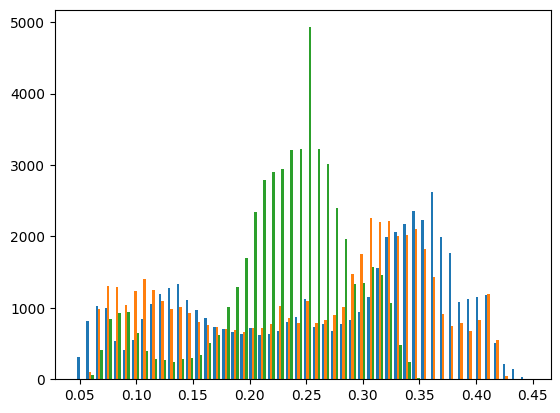

In [6]:
# get all the images in the dataset
images = train_dataset[0][0]

# convert images to numpy array
images = images.numpy()

# get all the pixel intensities
pixel_intensities = [img.flatten() for img in images]

# plot the histogram
plt.hist(pixel_intensities, bins=50)
plt.show()

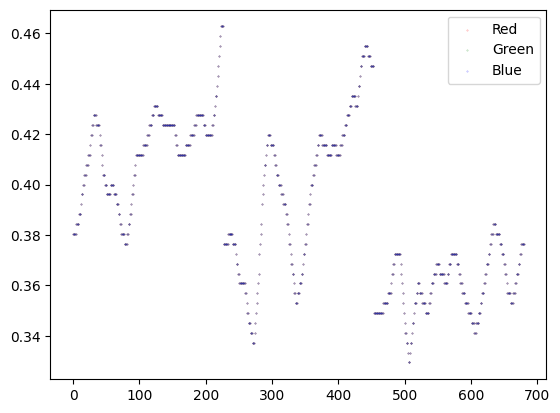

In [7]:
images = train_dataset[56][0]
intensities_r = np.ravel(images[:,:,0])
intensities_g = np.ravel(images[:,:,1])
intensities_b = np.ravel(images[:,:,2])

plt.scatter(range(len(intensities_r)), intensities_r, s=0.1, c='r', alpha=0.4, label='Red')
plt.scatter(range(len(intensities_g)), intensities_g, s=0.1, c='g', alpha=0.4, label='Green')
plt.scatter(range(len(intensities_b)), intensities_b, s=0.1, c='b', alpha=0.4, label='Blue')
plt.legend()
plt.show()

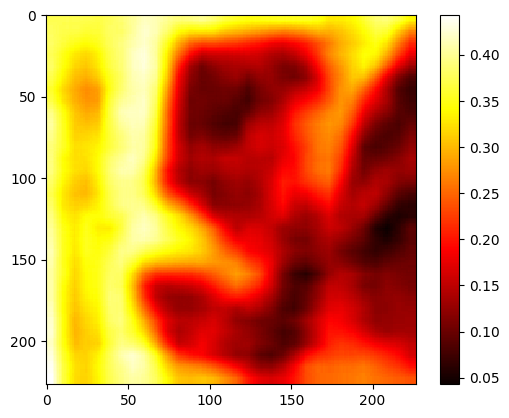

In [8]:
from torchvision.transforms import Grayscale
img_gray = Grayscale()(images)
img_array = np.array(img_gray)
img_array = img_array.squeeze()

plt.imshow(img_array, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## Splitting into Train and Validation

In [9]:
torch.manual_seed(64)
train_ds, val_ds = random_split(train_dataset, [int(0.8*len(train_dataset)), len(train_dataset)-int(0.8*len(train_dataset)), ])
len(train_ds), len(val_ds)

(58605, 14652)

In [10]:
# Create a DataLoader for efficient batching
train_dataloader = torch.utils.data.DataLoader(train_ds,batch_size=512)
val_dataloader = torch.utils.data.DataLoader(val_ds,batch_size=512)

In [11]:
# dataset[15]
print(len(train_dataloader))
print(len(val_dataloader))

115

29


## Creating Test Dataloader

In [12]:
test_dataloader = torch.utils.data.DataLoader(Test_dataset,batch_size=512)
print(len(test_dataloader))

51


## Defining Alexnet class and train/test functions 

In [13]:
class SVHN_AlexNet(nn.Module):
    def __init__(self):
        super(SVHN_AlexNet, self).__init__()
        
        # Define the layers of the network
        self.AlexNet=nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # nn.LocalResponseNorm(size=96),
        nn.BatchNorm2d(96),

        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # nn.LocalResponseNorm(size=256),
        nn.BatchNorm2d(256),
        
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),

        
        nn.Linear(in_features=256*6*6, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=10),
        nn.ReLU())
        
    def forward(self, x):
        # Define the forward pass of the network
        torch.manual_seed(64)
        x=self.AlexNet(x)

        return x


In [14]:
def train_loop(tr_dataloader, vl_dataloader, model, loss_fn, optimizer):
    tr_size = len(tr_dataloader.dataset)
    vl_size = len(vl_dataloader.dataset)
    tr_epoch_loss = 0.0
    vl_epoch_loss = 0.0
    vl_correct = 0
    
    for X, y in tr_dataloader:
        # print(X.size(0))
        # Compute prediction and loss
        X=X.to(device="cuda")
        pred = model(X)
        y = y.to(device="cuda")
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_epoch_loss += loss.item()*X.size(0)
    
    for X, y in vl_dataloader:
        X=X.to(device='cuda')
        result= model(X)
        y = y.to(device="cuda")
        loss = loss_fn(result, y)
        
        vl_epoch_loss += loss.item()*X.size(0)
        vl_correct += (result.argmax(1) == y).type(torch.float).sum().item()
    
    vl_correct/=vl_size
    print(f'Train epoch loss is {tr_epoch_loss/tr_size}')
    print(f'Validation epoch loss is {vl_epoch_loss/vl_size}')
    print(f"Validation Accuracy: {(100*vl_correct):>0.1f}%, Avg loss: {vl_epoch_loss/vl_size:>8f} \n")
    return tr_epoch_loss,vl_epoch_loss,vl_correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device="cuda"))
            y = y.to(device='cuda')
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(pred)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

## Running the Model

In [15]:
AlexNet_Model=SVHN_AlexNet().to(device="cuda")

# Initialize the loss function
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(AlexNet_Model.parameters(), lr=learning_rate)

epochs = 10
Train_epoch_loss_list=[]
Val_epoch_loss_list=[]
Val_epoch_acc_list=[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------") 
    tr_lss,vl_lss,vl_acc=train_loop(train_dataloader, val_dataloader, AlexNet_Model, loss_fn, optimizer)
    Train_epoch_loss_list.append(tr_lss)
    Val_epoch_loss_list.append(vl_lss)
    Val_epoch_acc_list.append(vl_acc)

test_loop(test_dataloader, AlexNet_Model, loss_fn)
print("Done!")

Epoch 1

-------------------------------

Train epoch loss is 2.281628181820243

Validation epoch loss is 2.260829005448375

Validation Accuracy: 18.4%, Avg loss: 2.260829 



Epoch 2

-------------------------------

Train epoch loss is 2.245869383422621

Validation epoch loss is 2.244694155355376

Validation Accuracy: 18.4%, Avg loss: 2.244694 



Epoch 3

-------------------------------

Train epoch loss is 2.229469762061218

Validation epoch loss is 2.2217448423574635

Validation Accuracy: 18.4%, Avg loss: 2.221745 



Epoch 4

-------------------------------

Train epoch loss is 2.1771480439110182

Validation epoch loss is 2.0903847814419865

Validation Accuracy: 26.1%, Avg loss: 2.090385 



Epoch 5

-------------------------------

Train epoch loss is 1.932066062948889

Validation epoch loss is 1.751522736864405

Validation Accuracy: 44.3%, Avg loss: 1.751523 



Epoch 6

-------------------------------

Train epoch loss is 1.5854425317140053

Validation epoch loss is 1.40689196

In [16]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------") 
    tr_lss,vl_lss,vl_acc=train_loop(train_dataloader, val_dataloader, AlexNet_Model, loss_fn, optimizer)
    Train_epoch_loss_list.append(tr_lss)
    Val_epoch_loss_list.append(vl_lss)
    Val_epoch_acc_list.append(vl_acc)

test_loop(test_dataloader, AlexNet_Model, loss_fn)
print("Done!")

Epoch 1

-------------------------------

Train epoch loss is 0.8451584434928305

Validation epoch loss is 0.8487302705364868

Validation Accuracy: 73.7%, Avg loss: 0.848730 



Epoch 2

-------------------------------

Train epoch loss is 0.7779559031412389

Validation epoch loss is 0.7874284763333578

Validation Accuracy: 76.6%, Avg loss: 0.787428 



Epoch 3

-------------------------------

Train epoch loss is 0.7228013526812601

Validation epoch loss is 0.7450951913032511

Validation Accuracy: 77.8%, Avg loss: 0.745095 



Epoch 4

-------------------------------

Train epoch loss is 0.6816964878186503

Validation epoch loss is 0.7109477232461284

Validation Accuracy: 79.5%, Avg loss: 0.710948 



Epoch 5

-------------------------------

Train epoch loss is 0.6447838114640502

Validation epoch loss is 0.6811698019878805

Validation Accuracy: 80.4%, Avg loss: 0.681170 



Epoch 6

-------------------------------

Train epoch loss is 0.6174391973121369

Validation epoch loss is 0.6

In [17]:
#Saving model
PATH = "svhn_model.pt"
torch.save(AlexNet_Model.state_dict(), PATH)

In [18]:
tst_acc,tst_loss=test_loop(test_dataloader, AlexNet_Model, loss_fn)

Test Error: 

 Accuracy: 84.8%, Avg loss: 0.601722 




## Evaluating the model

Text(0.5, 1.0, 'Train Lossvs Validation Loss')

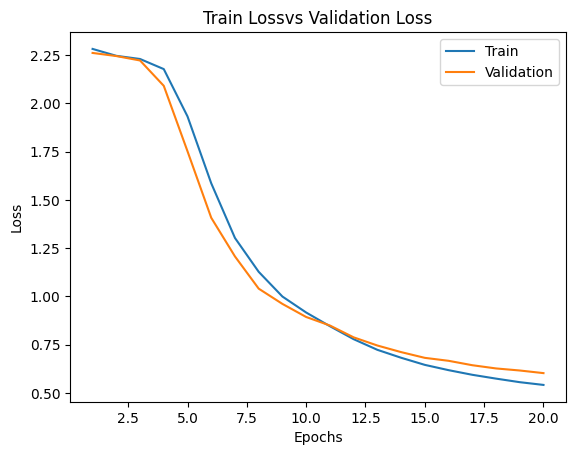

In [22]:
n1=len(train_dataloader.dataset)
n2=len(val_dataloader.dataset)

Train_epoch_loss_list=[x/n1 for x in Train_epoch_loss_list]
Val_epoch_loss_list=[x/n2 for x in Val_epoch_loss_list]

x1 = range(1,len(Train_epoch_loss_list)+1)
x2 = range(1,len(Val_epoch_loss_list)+1)

plt.plot(x1, Train_epoch_loss_list, label='Train')
plt.plot(x2, Val_epoch_loss_list, label='Validation')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')


Text(0.5, 1.0, 'Validation vs Test Accuracy')

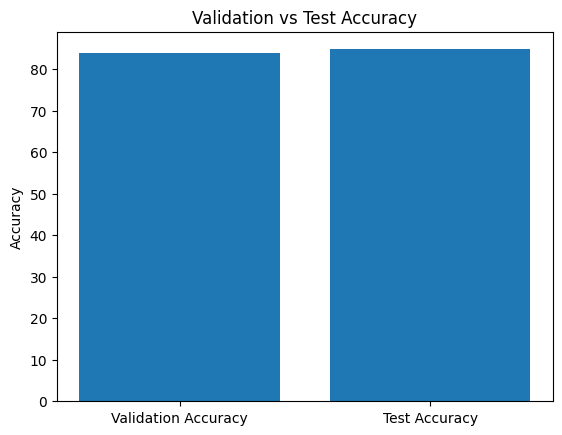

In [20]:
plt.bar(['Validation Accuracy', 'Test Accuracy'], [Val_epoch_acc_list[-1]*100, tst_acc*100])

plt.ylabel('Accuracy')

plt.title('Validation vs Test Accuracy')

Text(0.5, 1.0, 'SVHN Dataset \nValidation Loss vs Epoch')

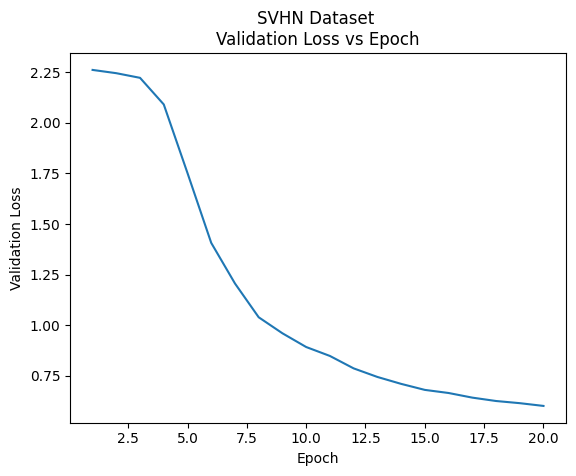

In [23]:
x_values = range(1, len(Val_epoch_loss_list) + 1)
plt.plot(x_values, Val_epoch_loss_list)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('SVHN Dataset \nValidation Loss vs Epoch')